
![delensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example - fast Wiener filter
In this notebook you perfrom QE and iterative lensing reconstruction for a single simulation, and for the full sky.
The simulations are created upon runtime inclusive of isotropic white noise and without foregrounds, using a built-in CMB-simulations module.
At the end of this tutorial, you will plot the lensing potential estimates and obtain delensed power spectra to calculate the residual lensing amplitude.

The configuration file is [here](./conf_mwe_fastWF.py), and you can freely change the parameters to your liking. In this configuration file, there are a few objects:

 * `DLENSALOT_Analysis` collects all configurations for the analysis of the data/simulations
 * `DLENSALOT_Simulationdata` configures the data which is used. In this minimal working example, we generate the simulation data on the fly and therefore need to choose the simulation module and a few parameters for this
 * `DLENSALOT_Noisemodel` configures the noise model with which the Wiener-filtering is done. 
 * `DLENSALOT_Qerec` and `DLENSALOT_Itrec` are lensing reconstruction specific settings.


Notes
 * rhits_normalized should be more a path to inverse pixel noise map

In [17]:
from IPython.display import clear_output
from datetime import datetime

import os
from os.path import join as opj

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import delensalot
from delensalot.run import run
from delensalot import utils
from delensalot.utility.utils_hp import alm_copy, almxfl
from delensalot.utility import plot_helper as ph

from delensalot.utility.plot_helper import movavg

fn = opj(os.getcwd(), 'conf_mwe_fastWF.py')

# QE lensing reconstruction
The following cell,
 
 * line 1: initialises delensalot for a QE lensing reconstruction job (`job_id`) and the [configuration file](./conf_mwe_fastWF.py) ,
 * line 2: perfroms lensing reconstruction and calculates both, the lensing potential, and the B-lensing template.

When run for the first time, `.run()` generates CMB simulations.

In [2]:
delensalot_runner = run(config_fn=fn, job_id='QE_lensrec', verbose=True)
delensalot_runner.run()
ana_mwe = delensalot_runner.init_job()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 14:50:52


# iterative lensing reconstruction

The following cell repeats above, but for the iterative case. The number of iterations is defined in `DLENSALOT_Itrec.itmax`.
For the iterative Wiener-filtering we use approximate solutions, allowing us to get fast results in this tutorial's idealized setting.

In [3]:
delensalot_runner = run(config_fn=fn, job_id='MAP_lensrec', verbose=True)
delensalot_runner.run()
ana_mwe = delensalot_runner.init_job()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 15:03:06


# Check your results
## lensing potential
After completion of above cells, you may want to see the reconstructed lensing potential.
`get_plm_it(idx, its)` returns the spherical harmonics for simulation `idx` and iterations `its`.

In [4]:
plm_QE = ana_mwe.get_plm_it(ana_mwe.simidxs[0], [0])[0]
plm_MAP = ana_mwe.get_plm_it(ana_mwe.simidxs[0], [ana_mwe.itmax])[0]
plm_in = alm_copy(ana_mwe.simulationdata.get_sim_phi(0, space='alm'), ana_mwe.simulationdata.phi_lmax, *ana_mwe.lm_max_qlm)

ll = np.arange(0,ana_mwe.lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)

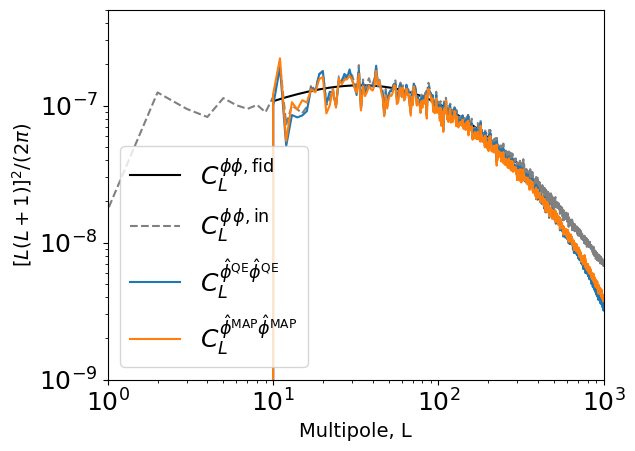

In [5]:
plt.plot(scale_factor*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$', color='black')
plt.plot(scale_factor*hp.alm2cl(plm_in), label=r'$C_L^{\phi^{\rm}\phi,{\rm in}}$', color='grey', ls='--')
plt.plot(scale_factor*hp.alm2cl(plm_QE), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')
plt.plot(scale_factor*hp.alm2cl(plm_MAP), label=r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$')

plt.legend(fontsize=18, loc='lower left')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-9,5e-7)
plt.yscale('log')

The blue line is the fiducial lensing potential. The QE and MAP estimates are shown in orange and green, and they agree well with the input. The drop at higher multipoles is due to the filtering. You will check the cross correlation to the input a bit below in this tutorial.

You can also compare them on map-level. We bandpass the multipoles to make the similarities more apparent

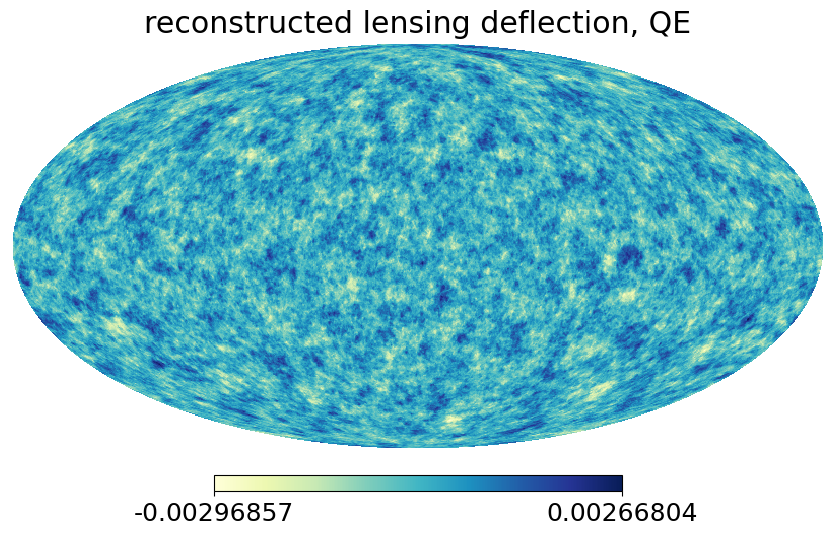

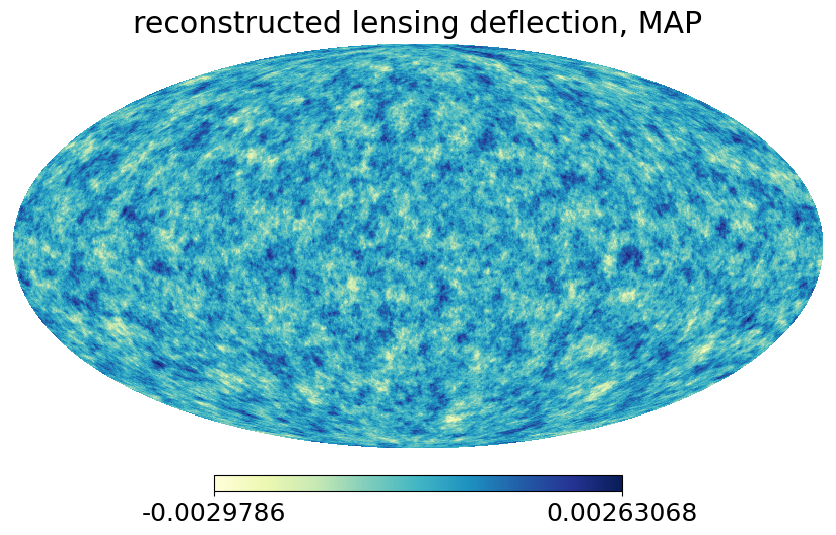

In [6]:
hp.mollview(hp.alm2map(ph.bandpass_alms(hp.almxfl(plm_QE,np.sqrt(ll*(ll+1))),10,1000), nside=512), title='reconstructed lensing deflection, QE', cmap='YlGnBu')
hp.mollview(hp.alm2map(ph.bandpass_alms(hp.almxfl(plm_MAP,np.sqrt(ll*(ll+1))),10,1000), nside=512), title='reconstructed lensing deflection, MAP', cmap='YlGnBu')

# Delensed spectrum
For both QE and iterative lensing reconstruction, delensalot already calculated the B-lensing templates. You can use them to delens the B-lensing maps and obtain residual maps.

(you could also use `delensalot`'s `job_id=delens`and initialize a job-model with it to have a few convenience functions for delensing, but this is only very useful on a masked sky)

In [7]:
blens_map = almxfl(alm_copy(ana_mwe.simulationdata.get_sim_sky(ana_mwe.simidxs[0], space='alm', spin=0, field='polarization')[1], ana_mwe.simulationdata.lmax, *ana_mwe.lm_max_blt), ana_mwe.ttebl['e'], ana_mwe.lm_max_blt[0], inplace=False) 
blt_QE = ana_mwe.get_blt_it(0, 0)
blt_MAP = ana_mwe.get_blt_it(0, ana_mwe.itmax)

blens_residual_QE = blens_map - blt_QE
blens_residual_MAP = blens_map - blt_MAP

INFO:: 06-14 15:09:10:: delensalot.sims.sims_lib.get_sim_sky - requesting "sky_spacealm_spin0_fieldpolarization_0"
INFO:: 06-14 15:09:10:: delensalot.sims.sims_lib.get_sim_sky - ..nothing cached..
INFO:: 06-14 15:09:10:: delensalot.sims.sims_lib.get_sim_sky - .., but stored on disk.
INFO:: 06-14 15:09:14:: delensalot.core.iterator.iteration_handler.log - get_datmaps() started
INFO:: 06-14 15:09:14:: delensalot.sims.sims_lib.get_sim_obs - requesting "obs_spacealm_spin0_fieldpolarization_0"
INFO:: 06-14 15:09:14:: delensalot.sims.sims_lib.get_sim_obs - ..nothing cached..
INFO:: 06-14 15:09:14:: delensalot.sims.sims_lib.get_sim_obs - .., but stored on disk.
INFO:: 06-14 15:09:16:: delensalot.core.iterator.iteration_handler.log - get_datmaps() finished


Text(0, 0.5, '$C_\\ell [\\mu $$\\rm{K}^2$]')

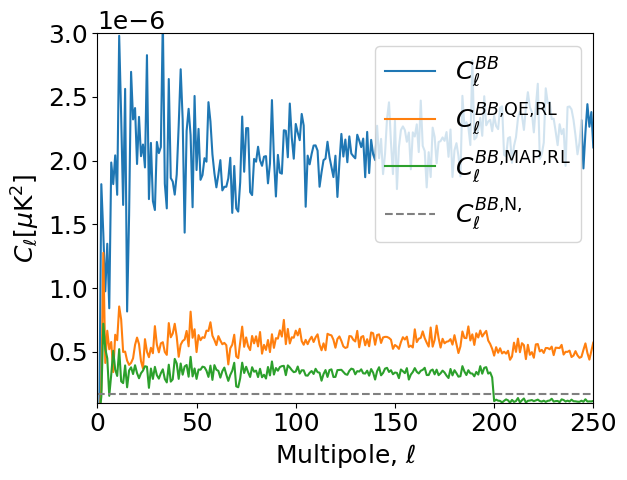

In [11]:
plt.plot(hp.alm2cl(blens_map), label=r'$C_\ell^{BB}$')
plt.plot(hp.alm2cl(blens_residual_QE), label=r'$C_\ell^{BB{,}{\rm QE{,}RL}}$')
plt.plot(hp.alm2cl(blens_residual_MAP), label=r'$C_\ell^{BB{,}{\rm MAP{,}RL}}$')

plt.hlines((ana_mwe.nlev['P']/180/60*np.pi)**2,0,500, color='grey', ls='--', label=r'$C_\ell^{BB{,}{\rm N{,}}}$')

plt.legend(loc='upper right')
plt.xlim(0,250)
plt.ylim(1e-7,3e-6)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('$C_\ell [\mu $'+r'$\rm{K}^2$]')

## residual lensing amplitude $A_{\rm lens}$
A simple estimate of the reduction of lensing power is to take the ratio between the input and resdiual B-lensing signal, averaged across the scales of interest. Here, we simply take the scales about the recombination peak

In [14]:
print(20*'~.')
print('nlev: {:.4}, lmax_ivf: {}, beam: {}'.format(str(ana_mwe.nlev), ana_mwe.lm_max_ivf, ana_mwe.beam))
print('A_{lens}^{QE}:'+'\t{:.3f}'.format(np.mean(hp.alm2cl(blens_residual_QE, lmax_out=200)[30:200]/hp.alm2cl(blens_map, lmax_out=200)[30:200])))
print('A_{lens}^{MAP}:'+'\t{:.3f}'.format(np.mean(hp.alm2cl(blens_residual_MAP, lmax_out=200)[30:200]/hp.alm2cl(blens_map, lmax_out=200)[30:200])))
print(20*'~.')

~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
nlev: {'P', lmax_ivf: (4000, 4000), beam: 1.0
A_{lens}^{QE}:	0.287
A_{lens}^{MAP}:	0.165
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.


# Summary and next steps
This tutorial demonstrated the usage of delensalot in an idealized setting, and you obtained lensing potential estimates and residual lensing amplitudes from simulation data generated upon runtime.

delensalot can also perfrom lensing reconstruction on more challenging settings such as,

 * masked sky,
 * inhomogeneous noise,
 * data inclusive of foreground (residuals).
 
Further, it can calculate reconstruction noise `N0`, and `N1`, and make analytical predictions for the delensed power spectra.
It also has MPI support.
 
Please check out the other tutorials, or see the [documentation](link_to_rtd_doc), or [github](https://github.com/NextGenCMB/delensalot) for more.

In [1]:
import unittest
import shutil
import os
from os.path import join as opj
import healpy as hp
import numpy as np

import delensalot
from delensalot.run import run
from delensalot import utils
from delensalot.utility.utils_hp import gauss_beam, alm_copy
from delensalot.config.visitor import transform, transform3d
from delensalot.config.transformer.lerepi2dlensalot import l2delensalotjob_Transformer, l2T_Transformer
from delensalot.config.metamodel.dlensalot_mm import DLENSALOT_Model, DLENSALOT_Analysis, DLENSALOT_Job, DLENSALOT_Itrec
from delensalot.core.opfilt import MAP_opfilt_aniso_p, MAP_opfilt_aniso_t, MAP_opfilt_iso_p, MAP_opfilt_iso_t, MAP_opfilt_iso_e, MAP_opfilt_iso_tp, QE_opfilt_aniso_p, QE_opfilt_aniso_t, QE_opfilt_iso_p, QE_opfilt_iso_t

key = 'p_p'
dlensalot_model = DLENSALOT_Model(defaults_to='P_FS_TEST', analysis = DLENSALOT_Analysis(key=key, TEMP_suffix='test'), itrec = DLENSALOT_Itrec(itmax=3))
delensalot.del_TEMP(transform(dlensalot_model, l2T_Transformer()))
delensalot_runner = run(config_fn='', job_id='generate_sim', config_model=dlensalot_model, verbose=True)
ana_mwe = delensalot_runner.init_job()
bsky = ana_mwe.simulationdata.get_sim_sky(simidx=0, field='polarization', space='alm', spin=0)[1]
obs = ana_mwe.simulationdata.get_sim_obs(simidx=0, field='polarization', space='alm', spin=0)

cond4mpi does not exists. No MPI loaded
mpi.py: Plancklens.mpi disabled as per environ variable 

INFO:: 06-14 16:43:28:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - analysis: couldnt find matching default value for reconstruction_method
INFO:: 06-14 16:43:28:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - noisemodel: couldnt find matching default value for zbounds
INFO:: 06-14 16:43:28:: delensalot.config.handler.log - store() Started
INFO:: 06-14 16:43:28:: delensalot.config.handler.store - 
INFO:: 06-14 16:43:28:: root.store - Matching config file found. Resuming where I left off.
INFO:: 06-14 16:43:28:: root.store - /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/analysis/test_lminB200/
INFO:: 06-14 16:43:28:: delensalot.config.handler.log - store() Finished
INFO:: 06-14 16:43:29:: delensalot.core.handler.__init__ - obs data will be stored at /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/simul

In [2]:
job_id = 'QE_lensrec'
use_approximateWF=True
if job_id == 'QE_lensrec':
    dlensalot_model.itrec.itmax = 0
blt = delensalot.map2tempblm(
    hp.alm2map_spin(obs, nside=ana_mwe.simulationdata.geominfo[1]['nside'], spin=2, lmax=ana_mwe.simulationdata.lmax), 
    lmax_cmb=dlensalot_model.analysis.lm_max_ivf[0], 
    beam=dlensalot_model.analysis.beam, 
    itmax=dlensalot_model.itrec.itmax, 
    nlev=dlensalot_model.noisemodel.nlev, 
    use_approximateWF=use_approximateWF, 
    defaults_to='P_FS_TEST', 
    verbose=True, )

INFO:: 06-14 16:43:52:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - analysis: couldnt find matching default value for reconstruction_method
INFO:: 06-14 16:43:52:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - noisemodel: couldnt find matching default value for zbounds
INFO:: 06-14 16:43:52:: delensalot.config.handler.log - store() Started
INFO:: 06-14 16:43:52:: delensalot.config.handler.store - 
INFO:: 06-14 16:43:52:: root.store - Matching config file found. Resuming where I left off.
INFO:: 06-14 16:43:52:: root.store - /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/analysis/0470_lminB200/
INFO:: 06-14 16:43:52:: delensalot.config.handler.log - store() Finished
INFO:: 06-14 16:43:53:: delensalot.core.mpi.inner_function - rank: 0, size: 1, name: x86_64 with 12 cpus
INFO:: 06-14 16:43:53:: delensalot.core.handler.__init__ - Will use data provided in memory
INFO:: 06-14 16:43:53:: delensalot.core.mpi.inner_function - rank:

/mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/plancklens/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


INFO:: 06-14 16:43:53:: delensalot.core.mpi.inner_function - rank: 0, size: 1, name: x86_64 with 12 cpus
INFO:: 06-14 16:43:53:: delensalot.config.handler.log - run() Started
INFO:: 06-14 16:43:53:: delensalot.core.handler.log - Sim.collect_jobs() started
INFO:: 06-14 16:43:53:: delensalot.core.handler.log - Sim.collect_jobs() finished: jobs=[[], []]
INFO:: 06-14 16:43:53:: delensalot.core.handler.log - Sim.collect_jobs() started
INFO:: 06-14 16:43:53:: delensalot.core.handler.log - Sim.collect_jobs() finished: jobs=[[], []]
INFO:: 06-14 16:43:53:: delensalot.core.handler.run - 0, task calc_phi started, jobs: [0]
INFO:: 06-14 16:43:53:: delensalot.core.handler.log - Sim.run() started
INFO:: 06-14 16:43:53:: delensalot.core.handler.log - Sim.run() finished
INFO:: 06-14 16:43:53:: delensalot.core.handler.log - Sim.run() started
INFO:: 06-14 16:43:53:: delensalot.core.handler.log - Sim.run() finished
INFO:: 06-14 16:43:53:: delensalot.core.handler.run - 0, task calc_phi started
INFO:: 06-

In [3]:
bsky = alm_copy(bsky, None, hp.Alm.getlmax(blt.size), hp.Alm.getlmax(blt.size))
input = hp.alm2cl(bsky, lmax=200)
output = hp.alm2cl(bsky-blt, lmax=200)
Al = np.mean(output[30:200]/input[30:200])
print(Al)

0.28669273301356524


In [4]:
import unittest
import shutil
import os
from os.path import join as opj
import healpy as hp
import numpy as np

import delensalot
from delensalot.run import run
from delensalot import utils
from delensalot.utility.utils_hp import gauss_beam, alm_copy
from delensalot.config.visitor import transform, transform3d
from delensalot.config.transformer.lerepi2dlensalot import l2delensalotjob_Transformer, l2T_Transformer
from delensalot.config.metamodel.dlensalot_mm import DLENSALOT_Model, DLENSALOT_Analysis, DLENSALOT_Job, DLENSALOT_Itrec
from delensalot.core.opfilt import MAP_opfilt_aniso_p, MAP_opfilt_aniso_t, MAP_opfilt_iso_p, MAP_opfilt_iso_t, MAP_opfilt_iso_e, MAP_opfilt_iso_tp, QE_opfilt_aniso_p, QE_opfilt_aniso_t, QE_opfilt_iso_p, QE_opfilt_iso_t

key = 'p_p'
dlensalot_model = DLENSALOT_Model(defaults_to='P_FS_TEST', analysis = DLENSALOT_Analysis(key=key, TEMP_suffix='test'), itrec = DLENSALOT_Itrec(itmax=3))
delensalot.del_TEMP(transform(dlensalot_model, l2T_Transformer()))
delensalot_runner = run(config_fn='', job_id='generate_sim', config_model=dlensalot_model, verbose=True)
ana_mwe = delensalot_runner.init_job()
bsky = ana_mwe.simulationdata.get_sim_sky(simidx=0, field='polarization', space='alm', spin=0)[1]
obs = ana_mwe.simulationdata.get_sim_obs(simidx=0, field='polarization', space='alm', spin=0)

INFO:: 06-14 16:45:20:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - analysis: couldnt find matching default value for reconstruction_method
INFO:: 06-14 16:45:20:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - noisemodel: couldnt find matching default value for zbounds
INFO:: 06-14 16:45:20:: delensalot.config.handler.log - store() Started
INFO:: 06-14 16:45:20:: delensalot.config.handler.store - 
INFO:: 06-14 16:45:20:: root.store - Matching config file found. Resuming where I left off.
INFO:: 06-14 16:45:20:: root.store - /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/analysis/test_lminB200/
INFO:: 06-14 16:45:20:: delensalot.config.handler.log - store() Finished
INFO:: 06-14 16:45:20:: delensalot.core.handler.__init__ - obs data will be stored at /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/simulation/('healpix', {'nside': 1024})/('thingauss', {'lmax': 3000, 'smax': 3})/{'P': 1.0, 'T': 0.7071

In [5]:
job_id = 'MAP_lensrec'
use_approximateWF=True
if job_id == 'QE_lensrec':
    dlensalot_model.itrec.itmax = 0
blt = delensalot.map2tempblm(
    hp.alm2map_spin(obs, nside=ana_mwe.simulationdata.geominfo[1]['nside'], spin=2, lmax=ana_mwe.simulationdata.lmax), 
    lmax_cmb=dlensalot_model.analysis.lm_max_ivf[0], 
    beam=dlensalot_model.analysis.beam, 
    itmax=dlensalot_model.itrec.itmax, 
    nlev=dlensalot_model.noisemodel.nlev, 
    use_approximateWF=use_approximateWF, 
    defaults_to='P_FS_TEST', 
    verbose=True, )

INFO:: 06-14 16:45:46:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - analysis: couldnt find matching default value for reconstruction_method
INFO:: 06-14 16:45:46:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - noisemodel: couldnt find matching default value for zbounds
INFO:: 06-14 16:45:46:: delensalot.config.handler.log - store() Started
INFO:: 06-14 16:45:46:: delensalot.config.handler.store - 
INFO:: 06-14 16:45:46:: root.store - Matching config file found. Resuming where I left off.
INFO:: 06-14 16:45:46:: root.store - /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/analysis/0470_lminB200/
INFO:: 06-14 16:45:46:: delensalot.config.handler.log - store() Finished
INFO:: 06-14 16:45:46:: delensalot.core.mpi.inner_function - rank: 0, size: 1, name: x86_64 with 12 cpus
INFO:: 06-14 16:45:46:: delensalot.core.handler.__init__ - Will use data provided in memory
INFO:: 06-14 16:45:46:: delensalot.core.mpi.inner_function - rank:

In [6]:
bsky = alm_copy(bsky, None, hp.Alm.getlmax(blt.size), hp.Alm.getlmax(blt.size))
input = hp.alm2cl(bsky, lmax=200)
output = hp.alm2cl(bsky-blt, lmax=200)
Al = np.mean(output[30:200]/input[30:200])
print(Al)

0.14359796451782994


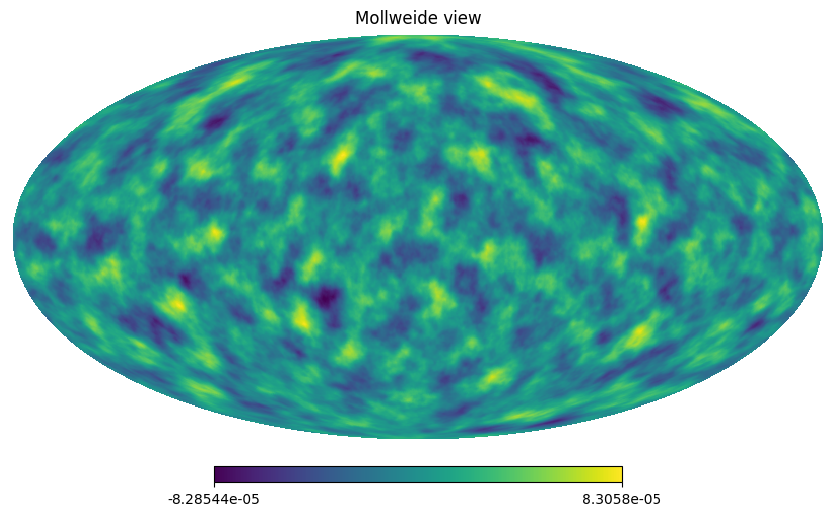

In [15]:
hp.mollview(hp.alm2map(np.load('/mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/analysis/9b2e_lminB200/MAP/p_p/sim0000noMF/phi_plm_it000.npy'), nside=512))

[]

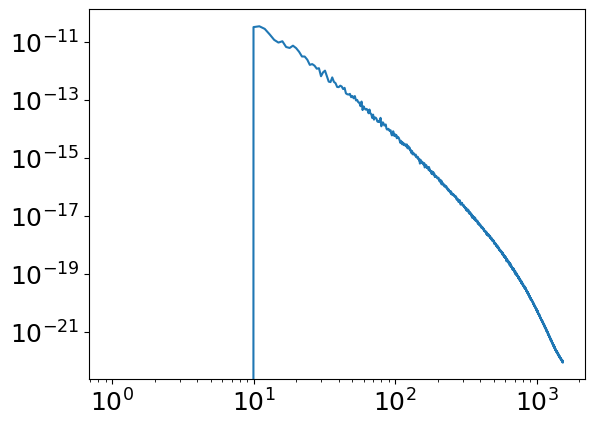

In [19]:
plt.plot(hp.alm2cl(np.load('/mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/analysis/9b2e_lminB200/MAP/p_p/sim0000noMF/phi_plm_it000.npy')))
plt.loglog()